In [1]:
# set working dir
import os
os.chdir("../")      

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from run import utils

In [3]:
# init config
config = SimpleNamespace()
config.prob = "sp"
config.grid = (5, 5)
config.feat = 5
config.net = []
config.optm = "adam"
config.batch = 32
config.l1 = 0.0
config.l2 = 0.0
config.rel = False
config.lan = "gurobi"
config.proc = 32
config.path = "./res"

In [4]:
# polynomial degree
degs = [1, 2, 4, 6]

In [5]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "lr":
        config.mthd = "2s"
        config.pred = "lr"
    if mthd == "rf":
        config.mthd = "2s"
        config.pred = "rf"
    if mthd == "spo":
        config.mthd = "spo"
        config.lr = 1e-3
    if mthd == "bb":
        config.mthd = "bb"
        config.lr = 5e-4
        config.smth = 20
    path = utils.getSavePath(config)
    return path

In [6]:
def getDf(config, degs, mthd):
    dfs = pd.DataFrame()
    for deg in degs:
        config.deg = deg
        df = pd.read_csv(getPath(config, mthd))
        dfs[deg] = df["Unamb SPO"]
    return dfs

In [7]:
def drawPlot(config, data, noise):
    # set config
    config = deepcopy(config)
    config.data = data
    config.noise = noise
    # get df
    df_lr  = getDf(config, degs, "lr")
    df_rf  = getDf(config, degs, "rf")
    df_spo = getDf(config, degs, "spo")
    df_bb  = getDf(config, degs, "bb")
    # draw boxplot
    plt.figure(figsize=(12,9))
    plt.boxplot(df_lr, boxprops=dict(facecolor="g", color="k"), medianprops=dict(color="k"), 
                patch_artist=True, positions=np.arange(df_spo.shape[1])-0.3, widths=0.18)
    plt.boxplot(df_rf, boxprops=dict(facecolor="r", color="k"), medianprops=dict(color="k"), 
                patch_artist=True, positions=np.arange(df_spo.shape[1])-0.1, widths=0.18)
    plt.boxplot(df_spo, boxprops=dict(facecolor="c", color="k"), medianprops=dict(color="k"), 
                patch_artist=True, positions=np.arange(df_spo.shape[1])+0.1, widths=0.18)
    plt.boxplot(df_bb, boxprops=dict(facecolor="m", color="k"), medianprops=dict(color="k"), 
                patch_artist=True, positions=np.arange(df_spo.shape[1])+0.3, widths=0.18)
    plt.xlabel('Deg', fontsize=24)
    plt.xticks(ticks=[0,1,2,3], labels=[1,2,4,6], fontsize=18)
    plt.ylabel('Normalized SPO Loss', fontsize=24)
    plt.yticks(fontsize=18)
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.02, 0.25)
    plt.title("Training Set Size = {},\nNoise Half−width = {}".format(config.data, config.noise), fontsize=18)
    plt.legend(["2-stage LR", "2-stage RF", "SPO+","Black-Box"], labelcolor=['g', 'r', 'c','m'], fontsize=16)
    plt.show()

## n = 100, e = 0

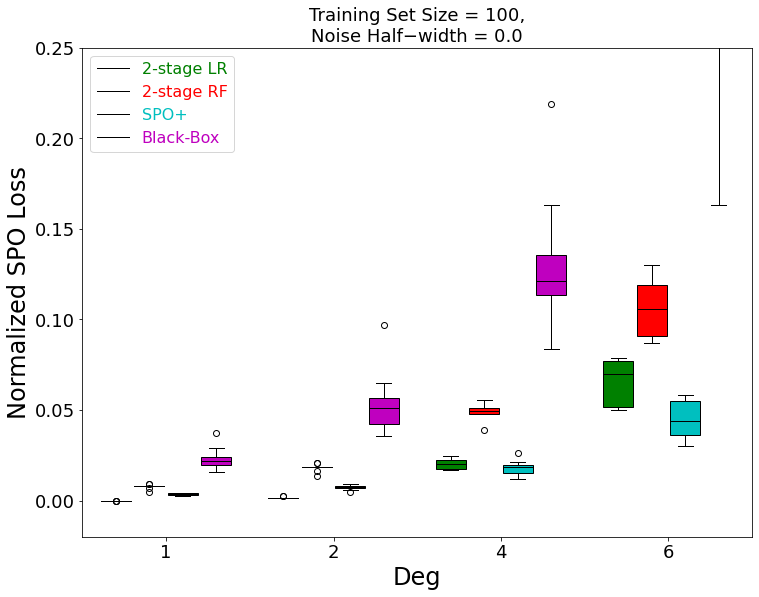

In [8]:
drawPlot(config, data=100, noise=0.0)

## n = 100, e = 0.5 

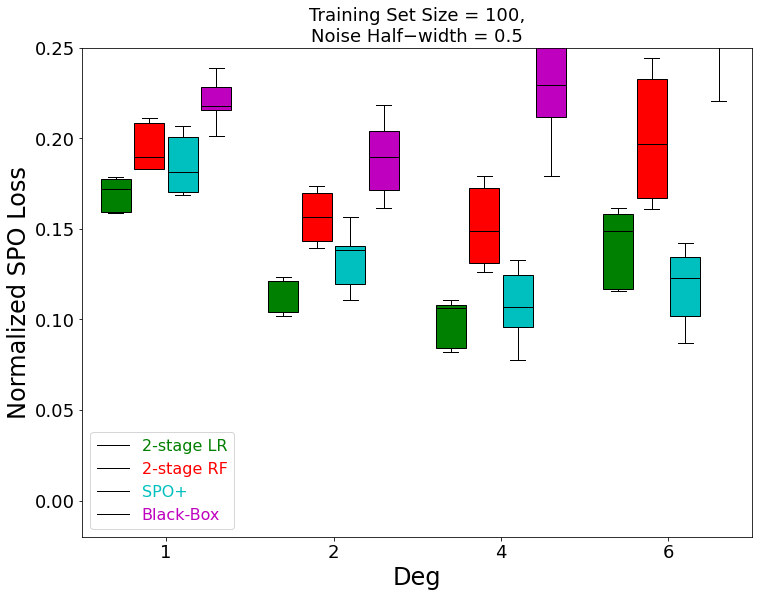

In [9]:
drawPlot(config, data=100, noise=0.5)

# n = 1000, e = 0

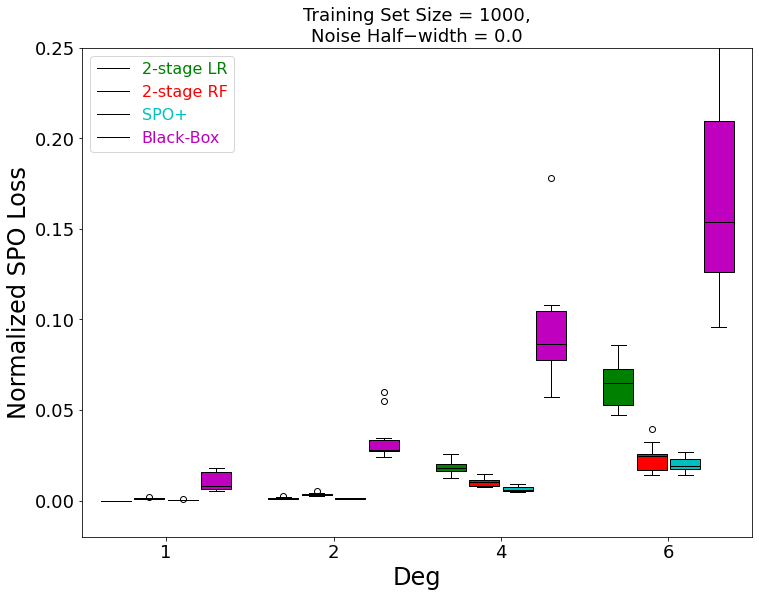

In [10]:
drawPlot(config, data=1000, noise=0.0)

## n = 1000, e = 0.5 

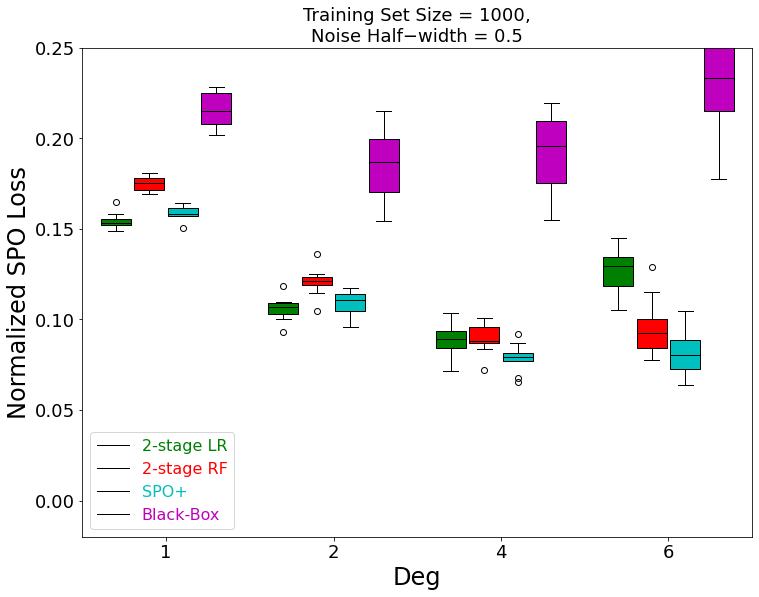

In [11]:
drawPlot(config, data=1000, noise=0.5)